# Define the parameters

In [ ]:
# copy file path
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.data'
TEST_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.test'
NAME_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.names'

# define the column name of the dataset, required
column_name = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]


drop_na = True

# Setup

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
from pandas.core.frame import DataFrame
def adult_feature_engineering(df:DataFrame):
  df['native-country']=np.where(df['native-country']==' United-States',1,0)
  df['marital-status']=np.where(df['marital-status']==' Married',1,0)
  df['workClass']=np.where(df['workClass']==' Private',1,0)
  df['sex']=np.where(df['sex']==' Male',1,0)
  df['race']=np.where(df['race']==' White',1,0)

  # income < 50k is 0, otherwise 1
  df['income']=np.where(np.logical_or(df['income']==' <=50K', df['income']==' <=50K.'),0,1)
  
  # Not sure how to encode education, relationship, and occupation using one-hot

  return df


In [ ]:
def f_load_data(TRAIN_DATASET_PATH:str,
                TEST_DATASET_PATH:str,
                drop_na:bool = True,
                column_name:list = None,
                ):
  assert(column_name != None)
  train_dataset = pd.read_csv(TRAIN_DATASET_PATH, index_col=False, header=None, na_values='?',
                              names=column_name)
  
  test_dataset = pd.read_csv(TEST_DATASET_PATH, index_col=False, header=None, na_values='?',
                             names=column_name, skiprows=1)
  if drop_na == True:
    train_dataset.dropna(inplace=True)
    test_dataset.dropna(inplace=True)

  print(f'shape of train: {train_dataset.shape}')
  print(f'shape of test: {test_dataset.shape}')

  combined_dataset = pd.concat([train_dataset,test_dataset])

  
  obj_col = combined_dataset.select_dtypes(include=['object'])
  int_col = combined_dataset.select_dtypes(include=['int64'])
  #print(int_col.columns)


  for col in int_col:
    mean = combined_dataset[col].mean()
    std = combined_dataset[col].std()
    combined_dataset[col]=(combined_dataset[col]-mean)/std

  #scalar = StandardScaler()
  #tmp = scalar.fit_transform(combined_dataset[int_col.columns])
  #combined_dataset.drop(int_col, axis=1, inplace=True)
  #combined_dataset = np.hstack((combined_dataset.values, tmp))

  #combined_dataset = pd.get_dummies(combined_dataset,obj_col.columns)
  combined_dataset = adult_feature_engineering(combined_dataset)

  #display(combined_dataset)
  #combined_dataset.head()
  #combined_dataset.info()

  #train_dataset.info()
  #test_dataset.info()
  #train_dataset.head()
  
  #print(combined_dataset)
  #combined_dataset.head()
  index = train_dataset.shape[0]

  train_dataset = combined_dataset.iloc[:index,:]
  test_dataset = combined_dataset.iloc[index:,:]
  return train_dataset, test_dataset

train_dataset, test_dataset = f_load_data(TRAIN_DATASET_PATH, TEST_DATASET_PATH,  True, column_name)
train_dataset.head()
print(f'shape of train: {train_dataset.shape}')
print(f'shape of test: {test_dataset.shape}')
display(train_dataset)

shape of train: (32561, 15)
shape of test: (16281, 15)
shape of train: (32561, 15)
shape of test: (16281, 15)


,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.025996,0,-1.061968,Bachelors,1.136500,0,Adm-clerical,Not-in-family,1,1,0.146931,-0.217125,-0.034087,1,0
1,0.828300,0,-1.007094,Bachelors,1.136500,0,Exec-managerial,Husband,1,1,-0.144802,-0.217125,-2.213009,1,0
2,-0.046941,1,0.246031,HS-grad,-0.419331,0,Handlers-cleaners,Not-in-family,1,1,-0.144802,-0.217125,-0.034087,1,0
3,1.047110,1,0.426659,11th,-1.197247,0,Handlers-cleaners,Husband,0,1,-0.144802,-0.217125,-0.034087,1,0
4,-0.776309,1,1.408515,Bachelors,1.136500,0,Prof-specialty,Wife,0,0,-0.144802,-0.217125,-0.034087,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849245,1,0.640486,Assoc-acdm,0.747543,0,Tech-support,Wife,1,0,-0.144802,-0.217125,-0.195488,1,0
32557,0.098932,1,-0.334174,HS-grad,-0.419331,0,Machine-op-inspct,Husband,1,1,-0.144802,-0.217125,-0.034087,1,1
32558,1.411794,1,-0.357507,HS-grad,-0.419331,0,Adm-clerical,Unmarried,1,0,-0.144802,-0.217125,-0.034087,1,0
32559,-1.213929,1,0.111983,HS-grad,-0.419331,0,Adm-clerical,Own-child,1,1,-0.144802,-0.217125,-1.648104,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f916c2310>,
      dtype=object)

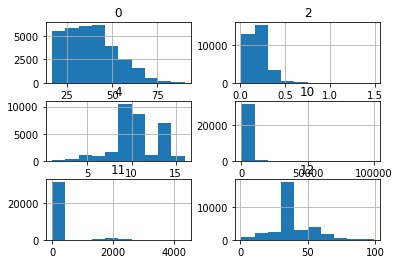

In [ ]:
num = train_dataset.select_dtypes(include=['int64', 'float64']).columns
subset = train_dataset[num]
subset.hist()

#Model Template

In [ ]:
# Template model
class Abernethy_p_sampling(object):
  def __init__(
      self,
      classifier,
      p:float32,
      ):
    self.p = p
  
  def train(
      self,
      ):
    return self.classifier
  
  def predict(
      self,
      ):
    return None
  
  def save(
      self,
      path:str):
    return None
  
  def load(
      self,
      path:str):
    return None

# Fairness Metric

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#self.true_data = train_dataset[[protected_col,label_col]].to_numpy()
# true_data is |protected_label | true_y |

class Fairness_metric(object):
  def __init__(
      self,
      protected_label:list,
      true_label:list,
      predict_label:list,
      ):
    assert(len(protected_label) == len(true_label))
    assert(len(predict_label) == len(true_label))
    self.protected_label = np.array(protected_label)
    self.predict_label = np.array(predict_label)
    self.true_label = np.array(true_label)
    self.res_mat = {}
    # res_mat: 
    # key : protected label 
    # val: [TP, FP, FN, TN]
    
  def process(self):
    for key in np.unique(self.protected_label):
      self.res_mat[key] = [0,0,0,0]
      # TP, FP, FN, TN
    for i in range(len(self.predict_label)):
      tmp_prot = self.protected_label[i]
      tmp_true = self.true_label[i]
      tmp_pred = self.predict_label[i]
      if tmp_true == tmp_pred and tmp_true == 1:
        # TP
        self.res_mat[tmp_prot][0] +=1
      elif tmp_true == 1 and tmp_pred == 0:
        # FN
        self.res_mat[tmp_prot][2] +=1
      elif tmp_true == 0 and tmp_pred == 1:
        # FP
        self.res_mat[tmp_prot][1] +=1
      elif tmp_true == 0 and tmp_pred == 0:
        # TN
        self.res_mat[tmp_prot][3] +=1
      else:
        print('Incorrect Code')

  # This is for two protected labels, can be adapted to multiple protected labels
  # output an label and its fairness violation
  def Demographic_Parity(
      self,
      ):
    output_label = None
    tmp_res = []
    # [label | violation]
    for label, tmp_list in self.res_mat.items():
      if output_label == None:
        output_label = label
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      tmp_res.append([TP+FP]/tot)

    return output_label ,tmp_res[0]-tmp_res[1]
  
  def Equal_Opportunity(
      self,
      ):
    output_label = None
    tmp_res = []
    # [label | violation]
    for label, tmp_list in self.res_mat.items():
      if output_label == None:
        output_label = label
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      tmp_res.append([TP]/tot)

    return output_label ,tmp_res[0]-tmp_res[1]
  
  def Equal_Odds(
      self,
      ):
    output_label = None
    tmp_res = []
    # [label | violation]
    for label, tmp_list in self.res_mat.items():
      if output_label == None:
        output_label = label
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      tmp_res.append([TP+FP]/tot)

    return output_label ,tmp_res[0]-tmp_res[1]

  def Overall_accuracy(
      self,
      ):
    output_label = None
    tmp_res = []
    # [label | violation]
    for label, tmp_list in self.res_mat.items():
      if output_label == None:
        output_label = label
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      tmp_res.append([TP+FN]/tot)

    return output_label ,tmp_res[0]-tmp_res[1]

In [ ]:
protected_label = [0, 1, 0, 1 , 1]
predict_label = [1,0,1,1,0]
true_label = [1, 1, 0, 1, 0 ]

metric = Fairness_metric(protected_label, true_label, predict_label)
metric.process()
print(metric.Overall_accuracy())

(0, array([-0.16666667]))
